### Topic Modeling Analysis
Felix Funes 20220306 | Paula Catalan 20221048 | Efstathia Styliagkatzi 20220078 | Alisson Tapia 20221156 | S M Abrar Hossain Asif 20220223


Topic modeling analysis offers valuable insights in various ways:

Uncovering underlying themes: Topic modeling allows for the discovery of latent themes or topics within a collection of documents. It reveals patterns and structures in large text datasets, eliminating the need for manual reading and categorization of each document.

Enhancing understanding of text corpora: Dealing with large amounts of text data can be overwhelming. Topic modeling helps by summarizing and organizing textual information into meaningful topics, facilitating exploration and comprehension of the dataset.

Enabling content recommendation and information retrieval: Topic modeling supports content recommendation systems by suggesting relevant items based on extracted topics from user preferences or queries. This improves search engines, recommender systems, and personalized content delivery by matching users' interests with relevant topics.

Facilitating text clustering and document classification: By assigning documents to different topics, topic modeling enables text clustering and document classification. It groups similar documents together based on thematic content, facilitating organization, retrieval, and analysis of the text data.

Driving market research and customer insights: Topic modeling can be applied to customer reviews, feedback, or social media data to identify prevalent topics and sentiments. It provides businesses with insights into customer preferences, concerns, and trends, aiding in product development, marketing strategies, and customer satisfaction analysis.

Supporting exploratory data analysis: Topic modeling serves as a powerful tool for exploratory data analysis. It offers a quick overview of the main themes present in a text dataset, identifies outliers or anomalies, and highlights areas for further investigation or research.

In [3]:
# Import packages
!pip install --user numpy==1.21.2


import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import gensim         
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [6]:
!pip install pyLDAvis
import spacy

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
pandas-profiling 3.3.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.
pandas-profiling 3.3.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
pandas-profiling 3.3.0 requires pandas!=1.4.0,<1.5,>1.1, but you have pandas 2.0.2 which is incompatible.
pandas-profiling 3.3.0 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.24.3 which is incompatible.


NameError: name 'pyLDAvis' is not defined

In [7]:
# Just because of versions on my computer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
# Load dataset
dtypes = {'type':'category','subreddit':'category','score':'float64','title':'category','reviews':'category','author':'category'}
ds= pd.read_excel("reddit_FINAL_v12.xlsx", sheet_name="Sheet1", engine='openpyxl', dtype=dtypes)

In [9]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    if type(rawText) != str:
        return rawText
    procText = rawText
        
    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText,'html.parser').get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove)>0:
        procText = re.sub(charsToRemove,' ',procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r'\d+',' ',procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace('\n',' ').replace('\r', '')

    # Remove special characters
    if len(specialCharsToRemove)>0:
        procText = re.sub(specialCharsToRemove,' ',procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower() 

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(' +', ' ', procText)

    return procText

In [10]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ''):
        return np.nan
    else:
        return word_tokenize(words)

In [11]:
# Function to create text from words
def recreateText(words):
    if type(words) == list:
        temp_str = (' ').join(words)
        return temp_str
    else:
        return np.nan

In [12]:
# Function to remove stop words
def removeStopWords(t, stop_words):
    if type(t) == list:
        return [w for w in t if not w in stop_words]
    else:
        return np.nan

In [13]:
# Function to lemmatize words
def lemmatize(words):
    if type(words) == list:
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(x) for x in words]
    else:
        return np.nan

In [15]:
dtypes = {'type':'category','subreddit':'category','score':'float64','title':'category','reviews':'category','author':'category'}
ds= pd.read_excel("reddit_FINAL_v12.xlsx", sheet_name="Sheet1", engine='openpyxl', dtype=dtypes)
print(ds.columns)  # Check column names

Index(['type', 'subreddit', 'title', 'reviews', 'author', 'date_published',
       'score'],
      dtype='object')


In [16]:
# Create a dataframe with only the description
processedReviews = pd.DataFrame(data=ds.reviews.apply(textPreProcess).values, index=ds.index, columns=['PreProcessedText'])

C:\Users\asifa\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://iaohi.com/products/aohi-magcube-65w-pd-fast-charger" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\asifa\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://preview.redd.it/yqvdvjj1r8wa1.jpeg?width=640&format=pjpg&auto=webp&v=enabled&s=10f145dc1c4c69eb3b08c6716b4ab2676564fe19" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [17]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asifa\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\asifa\AppData\Roaming\nltk_data...


True

In [18]:
# Tokekinze words
processedReviews['Words'] =  processedReviews['PreProcessedText'].apply(tokenize_words)

# Remove stopwords
stop_words = set(stopwords.words('english'))
processedReviews['WordsCleaned'] = processedReviews['Words'].apply(removeStopWords,stop_words=stop_words)

# Remove all reviews with no words
processedReviews = processedReviews[processedReviews['WordsCleaned'].str.len()>0]

# Lemmative words
processedReviews['WordsLemmatized'] = processedReviews['WordsCleaned'].apply(lemmatize)

In [19]:
# Create dictionary (needed for LDA)
id2word = corpora.Dictionary(processedReviews['WordsLemmatized'])

In [20]:
# Create corpus
corpus = processedReviews['WordsLemmatized']

In [21]:
# Create TDM (Frequency)
tdm = [id2word.doc2bow(text) for text in corpus]

In [22]:
# Build LDA model (can take from 2 to 10 minutes depending on the computer)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tdm,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
# Print the keywords in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[tdm]
# Interpretation: Topic 0 is represented as 0.055"walking" + 0.054"garden" + ...

[(0, '0.064*"phone" + 0.026*"need" + 0.023*"icloud" + 0.022*"use" + 0.020*"iphone" + 0.018*"want" + 0.014*"get" + 0.014*"apps" + 0.013*"got" + 0.012*"backup"'), (1, '0.040*"carrier" + 0.037*"sim" + 0.036*"esim" + 0.022*"phone" + 0.021*"[" + 0.021*"]" + 0.021*"know" + 0.020*"apple" + 0.015*"support" + 0.014*"take"'), (2, '0.044*"photo" + 0.026*"device" + 0.024*"think" + 0.023*"right" + 0.017*"like" + 0.016*"check" + 0.015*"thank" + 0.014*"video" + 0.014*"make" + 0.013*"show"'), (3, '0.026*"e" + 0.024*"http" + 0.021*"call" + 0.021*"someone" + 0.019*"sound" + 0.019*"%" + 0.019*"every" + 0.018*"fine" + 0.017*"//www" + 0.013*"lol"'), (4, '0.025*"u" + 0.023*"since" + 0.022*"problem" + 0.020*"case" + 0.017*"thanks" + 0.016*"http" + 0.016*"review" + 0.015*"battery" + 0.015*"thing" + 0.013*"good"'), (5, '0.034*"iphone" + 0.031*"new" + 0.026*"phone" + 0.024*"work" + 0.023*"n\'t" + 0.021*"get" + 0.019*"apple" + 0.018*"esim" + 0.016*"one" + 0.014*"would"'), (6, '0.063*"*" + 0.038*"even" + 0.020*"i

In [25]:
!pip install --upgrade pandas numpy scipy pyLDAvis


In [26]:
import pandas as pd
import numpy as np
import scipy
import pyLDAvis.gensim_models as gensimvis
import gensim

# Rest of your code


In [56]:
# Visualize the topics (can take some mintues to run)
#vis = pyLDAvis.gensim.prepare(lda_model, tdm, id2word)
#pyLDAvis.show(vis)

# If it is a newwer version of puLDavis, use this instead of the previous
#vis = gensimvis.prepare(lda_model, tdm, id2word)
#pyLDAvis.display(vis)

#pyLDAvis.enable_notebook() # Remove remarks to see in notebook instead of the browser

In [30]:
!pip install pyLDAvis



In [31]:
import pandas as pd
import numpy as np
import scipy
import pyLDAvis.gensim_models as gensimvis
import gensim
import pyLDAvis

# Your code before preparing the visualization

# Set n_jobs=1 in the prepare function call
vis = gensimvis.prepare(lda_model, tdm, id2word, n_jobs=1)

# Display the visualization
pyLDAvis.display(vis)

# Rest of your code


In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(tdm))  # lower value is better (some liteture do not recommend the use of this measure)


Perplexity:  -7.6675784890663685


In [38]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  -8.759232250404624


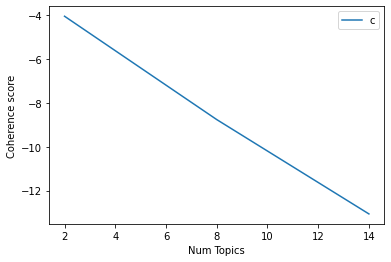

In [52]:
texts = processedReviews['WordsLemmatized'].tolist()

# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=upperBound, start=lowerBound, step=step)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


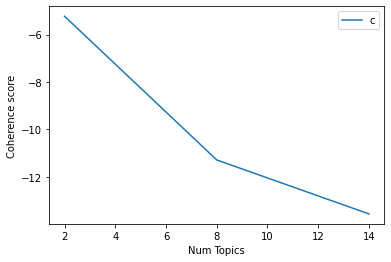

In [55]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import gensim
from bs4 import BeautifulSoup
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

def textPreProcess(rawText, removeHTML=True, charsToRemove=r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove=r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    if type(rawText) != str:
        return rawText
    procText = rawText
        
    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText,'html.parser').get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove)>0:
        procText = re.sub(charsToRemove,' ',procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r'\d+',' ',procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace('\n',' ').replace('\r', '')

    # Remove special characters
    if len(specialCharsToRemove)>0:
        procText = re.sub(specialCharsToRemove,' ',procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower() 

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(' +', ' ', procText)

    return procText

def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ''):
        return np.nan
    else:
        return word_tokenize(words)

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute UMass coherence for various numbers of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max number of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics,
                                               random_state=123,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Load and preprocess your texts
texts = processedReviews['PreProcessedText'].tolist()
processed_texts = [textPreProcess(doc) for doc in texts]
tokenized_texts = [tokenize_words(doc) for doc in processed_texts if isinstance(doc, str)]

# Create the dictionary and corpus
id2word = gensim.corpora.Dictionary(tokenized_texts)
corpus = [id2word.doc2bow(text) for text in tokenized_texts]

# Compute coherence values
lowerBound = 2
upperBound = 20
step = 6
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_texts, limit=upperBound, start=lowerBound, step=step)

# Show graph
x = range(lowerBound, upperBound, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

